In [1]:
# Run this cell to complete Chimera initialization
from pychimera import enable_chimera, enable_chimera_inline, chimera_view
enable_chimera()
enable_chimera_inline()
import chimera

You have used an unregistered copy of Chimera for 117 days.
You can either register now by visiting:
   http://www.cgl.ucsf.edu/cgi-bin/chimera_registration.py
or by choosing 'Registration...' from the 'Help' menu next
time you start Chimera with the gui enabled.

Registration is free.  By providing the information requested
you will be helping us document the impact this software is
having in the scientific community. The information you supply
will only be used for reporting summary statistics to NIH.


In [147]:
import os
from glob import glob
%matplotlib inline
from openmoltools.amber import run_antechamber
from openmoltools.utils import create_ffxml_file
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import nglview as nv

from gaudi.base import MolecularIndividual as Individual, expressed
from gaudi.genes.molecule import Molecule
from gaudi.objectives.energy import Energy

## Parametrize GPG and GPGG peptides
Careful, each can take up to four hours

In [ ]:
# Parametrize GPG
gpg_mol2 = './in2/peptide_GPG.mol2'
run_antechamber('GPG', gpg_mol2, net_charge=-6)

# Parametrize GPGG
gpgg_mol2 = './in2/peptide_GPGG.mol2'
run_antechamber('GPGG', gpgg_mol2, net_charge=-6)

In [ ]:
# Create ffxml
create_ffxml_file(['GPG.gaff.mol2', 'GPGG.gaff.mol2'], 
                  ['GPG.frcmod', 'GPGG.frcmod'], 
                  ffxml_filename='peptide_GPG+GPGG.ffxml')

## Evaluate MM energy of top 25 solutions of each topology

In [241]:
# GAUDI helpers
def individual(path):
    ind = Individual(dummy=True)
    ind.genes['Molecule'] = Molecule(parent=ind, path=path)
    ind.__ready__()
    ind.__expression_hooks__()
    return ind

def evaluate(individual, forcefields=['amber99sbildn.xml']):
    energy = Energy(forcefields=forcefields)
    with expressed(individual):
        return energy.evaluate(individual)

In [242]:
forcefields = ['amber99sbildn.xml', 'MD/in/peptide_GPG+GPGG.ffxml'] # provided by parametrization
gpg_energy = []
for path in sorted(os.listdir('output_gpg_2/best_pdb/')):
    gpg_energy.append(evaluate(individual(os.path.join('output_gpg_2/best_pdb/', path)), forcefields))

gpgg_energy = []
for path in sorted(os.listdir('output_gpgg_2/best_pdb/')):
    gpgg_energy.append(evaluate(individual(os.path.join('output_gpgg_2/best_pdb/', path)), forcefields))
  

# Results
print "GPG  - avg:", np.mean(gpg_energy), ", std:", np.std(gpg_energy)
print "GPGG - avg:", np.mean(gpgg_energy), ", std:", np.std(gpgg_energy)
print '\n', ("GPG", "GPGG")
print '\n'.join(map(str, zip(gpg_energy, gpgg_energy)))


GPG  - avg: 5801.41674487 , std: 352.957104253
GPGG - avg: 7489.02147331 , std: 191.572993893

('GPG', 'GPGG')
(6026.395157986076, 7661.691899638276)
(6019.572629594321, 7688.671696854046)
(5561.459514308079, 7427.613459392984)
(5505.637447665538, 7348.168947731534)
(5900.735420846696, 8112.7705092466895)
(5727.266698101513, 7364.368443961248)
(5655.101042710083, 7705.6672945276005)
(5681.5079963099215, 7459.081163368103)
(5649.752338170052, 7509.395261457181)
(7144.765921586235, 7474.713497463948)
(5645.335591634538, 7459.943658702725)
(6023.659457399702, 7322.4690442041565)
(5801.002930685782, 7629.507360046686)
(5642.294004446547, 7373.106332529927)
(5890.132765044309, 7331.553366147786)
(5519.808092546102, 7253.217202005597)
(5624.562725488584, 7285.436057770814)
(6268.164930379419, 7302.9033641479)
(5501.492434356542, 7534.862150379209)
(5611.745393778788, 7345.6696908752565)
(5631.572981323421, 7640.326399833466)
(6394.85506848891, 7573.701879812117)
(5529.117441123815, 7359.6383

# Trajectory analysis
Compare energies to those of unbound peptide, as provided by long MD simulations

In [283]:
def load_traj(traj, top, stride=1):
    gpg_traj = md.load(sorted(glob(traj)), top=top, stride=10)
    gpg_traj = gpg_traj.center_coordinates()
    return gpg_traj.superpose(gpg_traj)

def rmsd(traj):
    distances = np.empty((traj.n_frames, traj.n_frames))
    for i in xrange(traj.n_frames):
        distances[i] = md.rmsd(traj, traj, i, precentered=True)
    return distances

def clustering(distances):
    # Clustering only accepts reduced form. Squareform's checks are too stringent
    return scipy.cluster.hierarchy.ward(distances)

def cluster_groups(linkage, n=10):
    labels = scipy.cluster.hierarchy.fcluster(linkage, t=n, criterion='maxclust')
    indices = []
    frames = np.arange(gpg_traj.n_frames)
    for i in xrange(1, 11):
        indices.append(frames[labels==i])
    return indices

def rmsd_per_cluster(traj, labels):
    rmsds = []
    print "#\tSize \tAvg RMSD\tStd"
    for i, j in enumerate(labels):
        rmsd = md.rmsd(traj[j], traj[j], precentered=True)
        rmsds.append(rmsd)
        print i+1, "\t", len(j), "\t", np.mean(rmsd), "\t", np.std(rmsd)
    return rmsds
        
def cluster_plot(linkage):
    return scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

# Compute all energies!
def energy_evaluation(topology_pickle, traj):
    energy = Energy(forcefields=['amber99sbildn.xml', 'MD/in/peptide_GPG+GPGG.ffxml'])
    # Openmm keeps insisting on adding more bonds than needed if we use `traj.topology.to_openmm()`
    with open(topology_pickle, 'rb') as f:
        energy.topology = pickle.load(f)

    energies = np.empty(traj.n_frames)
    for i in xrange(traj.n_frames):
        energies[i] = energy.calculate_energy(traj.openmm_positions(i))

    for i, index in enumerate(indices):
        print i+1, "\t", np.mean(energies[index]), "\t", np.std(energies[index])

    return energies

## GPG Trajectory

In [268]:
# Load trajectory
gpg_traj = load_traj('MD/out_gpg/GPG_production.*.dcd', 'MD/in/GPG.pdb', 10)

In [ ]:
gpg_distances = rmsd(gpg_traj)
gpg_linkage = clustering(gpg_distances)
gpg_clusters = cluster_groups(gpg_linkage)

In [284]:
gpg_rmsd_per_cluster = rmsd_per_cluster(gpg_traj, gpg_clusters)

#	Size 	Avg RMSD	Std
1 	450 	0.229327 	0.0262471
2 	711 	0.324367 	0.0524819
3 	775 	0.170943 	0.0271215
4 	890 	0.236349 	0.0441672
5 	249 	0.242863 	0.0565465
6 	460 	0.235447 	0.0359178
7 	691 	0.214758 	0.0459535
8 	252 	0.31716 	0.104349
9 	233 	0.291823 	0.0611173
10 	239 	0.333355 	0.0475992


In [248]:
gpg_energies = energy_evaluation('MD/in/gpg_top.pickle2', gpg_traj)

1 	2853.36838563 	34.394501537
2 	2862.4676023 	39.527831472
3 	2914.82998652 	32.1596042622
4 	2920.11947273 	33.7717251613
5 	2926.69752215 	34.1158017029
6 	2918.62172293 	33.7502508198
7 	2918.12699048 	34.5373022673
8 	2910.42453312 	41.8699505854
9 	2930.15041651 	35.3301399394
10 	2890.69176451 	39.8193723896


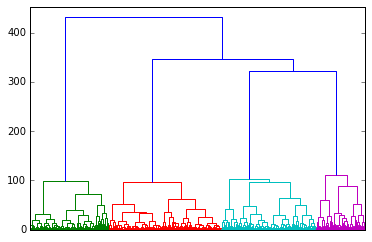

In [263]:
_ = plot(gpg_linkage)

In [309]:
# View a given cluster gorup
gpg_v = nv.show_mdtraj(gpg_traj[gpg_clusters[3]])
gpg_v.add_ball_and_stick()
gpg_v

In [340]:
gpg_v.render_image(frame=0, factor=0.5)
gpg_v.get_image()

## GPGG trajectory

In [281]:
gpgg_traj = load_traj('MD/out_gpgg/GPGG_production.*.dcd', 'MD/in/GPGG.pdb', 10)
gpgg_distances = rmsd(gpgg_traj)
gpgg_linkage = clustering(gpgg_distances)
gpgg_clusters = cluster_groups(gpgg_linkage)

In [285]:
gpgg_rmsd_per_cluster = rmsd_per_cluster(gpgg_traj, gpgg_clusters)

#	Size 	Avg RMSD	Std
1 	618 	0.126711 	0.0319571
2 	420 	0.171982 	0.0310005
3 	1148 	0.151698 	0.0240594
4 	860 	0.168242 	0.0503439
5 	417 	0.24033 	0.0819223
6 	50 	0.349584 	0.0625099
7 	170 	0.224965 	0.0612433
8 	422 	0.297485 	0.0697697
9 	509 	0.23584 	0.0500347
10 	336 	0.278733 	0.10652


In [286]:
gpgg_energies = energy_evaluation('MD/in/gpgg_top.pickle2', gpgg_traj)

1 	2930.13230474 	37.7537823348
2 	2931.58967883 	35.1762910393
3 	2934.79073629 	37.2335746511
4 	2931.20317947 	38.1451119308
5 	2934.32816576 	40.23206645
6 	2932.59533132 	35.7767889041
7 	2933.1065697 	36.328772533
8 	2936.87191834 	39.4444404194
9 	2937.46033615 	37.2712733116
10 	2926.88231848 	34.8737767293


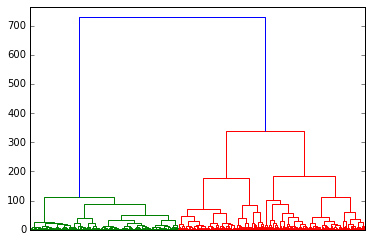

In [287]:
_ = plot(gpgg_linkage)

In [320]:
gpgg_v = nv.show_mdtraj(gpgg_traj[gpgg_clusters[2]])
gpgg_v.add_ball_and_stick()
gpgg_v

In [333]:
gpgg_v.render_image(frame=0, factor=0.5)
gpgg_v.get_image()